# Swag Labs DRL Testing Analysis

This notebook analyzes the 2 PPO models trained with Selenium for Swag Labs: https://www.saucedemo.com/

---

#### Goals 
- Display learning curves for both models, analyze and compare.
- Gather performance metrics and aggregate data.
- Compare per-episode metrics across 10 episodes per agent.
- Plot distributions for metrics, analyze patterns, explain with reward design.
  
---

#### Personas
- **Functional**: Prioritizes learning the full purchase flow (login → add item → go to cart → checkout → fill info → complete purchase).
- **Explorer**: Focuses on visiting/exploring as many pages as possible and interacting with as many elements as possible.

---
#### Notes
- Each agent was trained for 3,000 timesteps (due to Selenium being slow)
- These models aren't fully capable due to the low timesteps, but they should still differ quite a bit.

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

### 2. Learning Curves

Now, we can plot the learning curves for the two personas trained using PPO.
- Each plot itself represents a persona: *Functional*, *Explorer*
- The CSV data used for the plots is based off of the logs for each model, and downloaded as CSV from tensorboard.

The plots below show the learning curves of the ep_rew_mean (mean episode rewards) vs. the total timesteps during training.

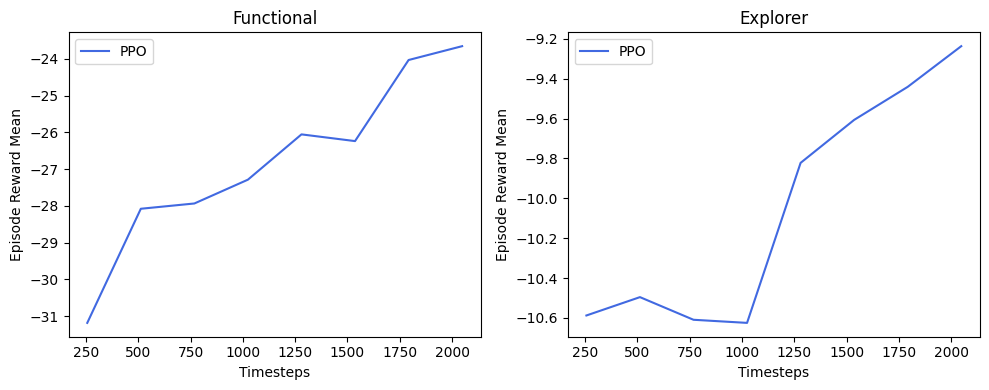

In [5]:
personas = ["functional", "explorer"]

import pandas as pd
import matplotlib.pyplot as plt

personas = ["functional", "explorer"]

fig, axes = plt.subplots(1, len(personas), figsize=(10, 4))
for i, persona in enumerate(personas):
    df = pd.read_csv(f"../data/swaglabs/PPO_{persona}_ep_rew_mean.csv")
    axes[i].plot(df["Step"], df["Value"], label="PPO", color="royalblue")

    axes[i].set_title(persona.capitalize())
    axes[i].set_xlabel("Timesteps")
    axes[i].set_ylabel("Episode Reward Mean")
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Analysis of Episode Reward Curves
Since these models were only trained on 2000 timesteps due to time constraints, the results here aren't perfect, but still provide some insight into the differences between reward designs early on.
- **Functional**: We see a more steady reward increase over time, this is likely due to this reward design focusing on learning the correct flow, so it slowly learns the correct actions in the sequence, and in just 2000 timesteps it wasn't able to achieve a high reward but still managed to show a steady increase.
  
- **Explorer**: This reward design is meant to access every page and selector, and not follow a specific flow. It is meant to be more random, and its graph shows a steady increase as well, with a bit of spikes. We can see that this agent was also able to learn how to maximize reward quickly even with limited training.

### 3. Performance Metrics

Now, we will import the CSV metrics files and clean and aggregate the data to discover trends. The agents were evaluated on 10 episodes each, so the CSV files contain 10 rows of data.

#### Load CSV Metrics

In [6]:
# File paths for each agent's metrics
paths = {
    "PPO_Functional": "../logs/swaglabs/swaglabs_ppo_functional_2000/metrics.csv",
    "PPO_Explorer": "../logs/swaglabs/swaglabs_ppo_explorer_2000/metrics.csv",
}

# Load all CSV metrics into pandas dataframes
dfs = {name: pd.read_csv(path) for name, path in paths.items()}

#### Compute and Aggregate Metrics

In [9]:
metrics = []

for name, df in dfs.items():
    avg_reward = df["total_reward"].mean().round(2)
    avg_success = df["total_success"].mean().round(2)
    avg_error = df["total_error"].mean().round(2)
    avg_steps = df["steps"].mean().round(2)
    success_rate = (df["total_success"] / (df["total_success"] + df["total_error"])).mean() * 100

    metrics.append({
        "Agent": name,
        "Avg Reward": avg_reward,
        "Avg Success": avg_success,
        "Avg Errors": avg_error,
        "Avg Steps": avg_steps,
        "Success Rate (%)": round(success_rate, 1)
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,Agent,Avg Reward,Avg Success,Avg Errors,Avg Steps,Success Rate (%)
0,PPO_Functional,-3.04,15.9,9.1,25.0,63.6
1,PPO_Explorer,-18.95,6.5,11.0,17.5,36.8


#### Metrics Analysis 

The metrics table summarizes the overall performance of both personas over 10 evaluation episodes. Since the data is only based on the 2000 timestep models, there isn't enough information to create meaningful distribution plots. However, we can still make a few conclusions based on the early training for both personas.

**Functional:**
* Achieved a higher average reward (-3.04) and success rate (63.6%) than the explorer persona. Its lower average error count (9.1) and full 25-step runs show that it consistently followed the expected flow and completed actions more reliably.

**Explorer**
* Had a lower average reward (-18.95) and success rate (36.8%), reflecting its exploratory behaviour. Since it’s designed to interact with many elements rather than follow a strict sequence, it naturally encountered more errors. 
  
* Additionally, at 2000 timesteps, this persona found that adding all of the items to the cart was the best way to gain reward. Once it ran out of items to add, it exited, resulting in less steps.

Overall, these results align with the intended behavior of each persona. The functional model focuses on following the correct flow and stability, while the explorer model prioritizes maximum coverage of actions and pages, even if it leads to more errors.

### 4. Conclusion

Overall, the PPO Swag Labs agents performed as expected for the amount of timesteps they were trained. The models showed clear differences in how each reward design shaped their behavior. The Functional agent focused more on following the correct sequence (logging in, adding to cart, and checking out) which led to higher success rates and more consistent runs. In contrast, the Explorer agent acted more randomly, clicking around different elements and pages to explore the app. It encountered more errors overall, which makes sense considering what it was designed to do.

Even though both models were only trained for 2000 timesteps, the results still show how reward shaping can completely change an agent’s behavior. The functional model acts like a normal user trying to complete a purchase, while the explorer behaves more like a tester for the software, trying out every possible action.